In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams

from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('data/aac_shelter_outcomes.csv')

In [3]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [4]:
data['outcome_type'].unique()

array(['Transfer', 'Adoption', 'Euthanasia', 'Return to Owner', 'Died',
       'Disposal', 'Relocate', 'Missing', nan, 'Rto-Adopt'], dtype=object)

In [5]:
data['outcome_type'].value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [6]:
data['sex_upon_outcome'].value_counts()

Neutered Male    27784
Spayed Female    25203
Intact Male       9549
Intact Female     9143
Unknown           6575
Name: sex_upon_outcome, dtype: int64

In [7]:
# По условию, нужно предсказать пару Adoption-Transfer, остальные строки удалаяем
# data[data['outcome_type']=='Adoption' or data['outcome_type']=='Transfer']
#data = data.query('outcome_type == "Adoption" or outcome_type == "Transfer"')

#Добавлено в версии 2 - удалим в конце, в строках есть полезная информация о повторных визитах

In [8]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78246 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78238 non-null object
animal_id           78246 non-null object
animal_type         78246 non-null object
breed               78246 non-null object
color               78246 non-null object
date_of_birth       78246 non-null object
datetime            78246 non-null object
monthyear           78246 non-null object
name                54365 non-null object
outcome_subtype     35958 non-null object
outcome_type        78234 non-null object
sex_upon_outcome    78244 non-null object
dtypes: object(12)
memory usage: 7.8+ MB


In [9]:
# Save profile report to file - open in another window more convinient for me
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile='report.html')

Итак - 12 столбцов, 78к строк, профайлер определяет как "категории", сам датафрейм видит только пропуски. 10 столбцов дублированы - убираем. Ниже комментарии по столбцам:
* age_upon_outcome - возраст при покидании приюта, описан в "человеческом" формате. Надо привести к цифрам. Есть 2 пропускa и несколько странных возрастов в днях. Разобрался - животные в приют не только поступают, но и рождаются там :). Пропуски по возрасту можно заполнить корректно - у всех НаН есть дата рождения и дата выхода из приюта. После преобразования столбцов с датами пересчитаем этот столбец.
* animal_id - ИД животного. Есть повторы - логично для приюта, сдают животных на передержку и каждый раз новая запись. возможно, стоит подумать о признаке повторного пребывания животного.
* animal_type - тип животного. 'Cat', 'Dog', 'Other', 'Bird', 'Livestock'. Домашний скот меня немного смущает, но пока пусть будет... Выкинуть всегда успеем - переносим в тип Other. 8 строк и куча признаков - модель не будет отлавливать 
* 'breed' - порода. Для типа Other - тип - белка, енот и т.п. Ничего толкового пока не придумал. Можно поробовать создать признак Mix/non-Mix.
* 'color' - 475 цветов. Я и 7 с трудом различаю)) пока не будем использовать
* 'date_of_birth' - день рождения. Надо просто преобразовать в нормальный формат
* 'datetime','monthyear' - время покидания приюта. Дропаем один, переименуем столбец left_date, время в часах вряд-ли влияет, распознаем данные
* 'name' - имя. Врядли само по себе имя имеет значение, а вот его наличие или отсутствие наверняка влияет. Меняем на 0/1 - нет/есть
* 'outcome_subtype' - дополнительный параметр при выходе из приюта. Послезнание - не нужен для модели
* 'outcome_type' - что надо предсказать. Заменим Transfer->0 Adoption->1
* 'sex_upon_outcome

In [10]:
data['age_upon_outcome'].unique()

array(['2 weeks', '1 year', '9 years', '5 months', '4 months', '3 years',
       '1 month', '3 months', '2 years', '2 months', '4 years', '8 years',
       '3 weeks', '8 months', '12 years', '7 years', '5 years', '6 years',
       '5 days', '10 months', '4 weeks', '10 years', '2 days', '6 months',
       '14 years', '11 months', '15 years', '7 months', '13 years',
       '11 years', '16 years', '9 months', '3 days', '6 days', '4 days',
       '5 weeks', '1 week', '1 day', '1 weeks', '0 years', '17 years',
       '20 years', '18 years', '19 years', '22 years', '25 years', nan],
      dtype=object)

In [11]:
# Playing with age
data[data['age_upon_outcome'].isna()]

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
68246,NaN,A737705,Dog,Labrador Retriever Mix,Black/White,2013-11-02T00:00:00,2016-11-19T16:35:00,2016-11-19T16:35:00,*Heddy,NaN,NaN,NaN
76825,NaN,A764319,Dog,Pit Bull Mix,Black/White,2016-12-27T00:00:00,2017-12-30T16:47:00,2017-12-30T16:47:00,*Emma,NaN,NaN,Intact Female
77976,NaN,A765547,Bird,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,2018-01-25T13:23:00,NaN,Partner,Transfer,Intact Female
78081,NaN,A765899,Dog,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,2018-01-29T15:49:00,NaN,Suffering,Euthanasia,Neutered Male
78114,NaN,A765914,Cat,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,2018-01-29T18:08:00,NaN,Suffering,Euthanasia,Intact Male
78162,NaN,A765901,Dog,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,2018-01-31T08:14:00,NaN,Partner,Transfer,Intact Male
78208,NaN,A765960,Dog,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,2018-02-01T09:21:00,NaN,Suffering,Euthanasia,Intact Male
78253,NaN,A766098,Other,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,2018-02-01T18:08:00,NaN,Rabies Risk,Euthanasia,Unknown


In [12]:
# Playing with ID
data[data['animal_id'] == 'A701901']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
27581,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2015-12-12T16:14:00,2015-12-12T16:14:00,Sasha,NaN,Return to Owner,Spayed Female
27933,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2016-04-02T16:45:00,2016-04-02T16:45:00,Sasha,Partner,Transfer,Spayed Female
28452,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2015-05-20T18:58:00,2015-05-20T18:58:00,Sasha,NaN,Return to Owner,Spayed Female
29184,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2015-09-16T12:20:00,2015-09-16T12:20:00,Sasha,Possible Theft,Missing,Spayed Female
43304,3 years,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2017-05-14T12:25:00,2017-05-14T12:25:00,Sasha,NaN,Return to Owner,Spayed Female
66271,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2015-05-15T19:09:00,2015-05-15T19:09:00,Sasha,NaN,Return to Owner,Spayed Female
68939,1 year,A701901,Dog,Pit Bull Mix,Blue,2014-05-06T00:00:00,2015-11-30T17:12:00,2015-11-30T17:12:00,Sasha,NaN,Return to Owner,Spayed Female


In [13]:
#Playing with animal_type
data['animal_type'].unique()

array(['Cat', 'Dog', 'Other', 'Bird', 'Livestock'], dtype=object)

In [14]:
data[data['animal_type'] == 'Livestock']

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
2240,6 months,A668167,Livestock,Pig Mix,Black/White,2013-05-28T00:00:00,2013-11-30T12:18:00,2013-11-30T12:18:00,NaN,NaN,Return to Owner,Intact Female
11609,6 months,A679540,Livestock,Goat Mix,Black,2013-11-22T00:00:00,2014-06-17T10:30:00,2014-06-17T10:30:00,NaN,Partner,Transfer,Intact Male
17291,5 years,A663228,Livestock,Miniature,Liver/Cream,2008-09-15T00:00:00,2013-10-03T10:59:00,2013-10-03T10:59:00,NaN,Partner,Transfer,Intact Male
19396,1 year,A673651,Livestock,Pig Mix,Black/White,2013-02-28T00:00:00,2014-03-11T14:39:00,2014-03-11T14:39:00,NaN,Foster,Adoption,Neutered Male
22609,5 weeks,A674214,Livestock,Pig Mix,Black,2014-02-22T00:00:00,2014-03-29T14:00:00,2014-03-29T14:00:00,NaN,Foster,Adoption,Unknown
31005,2 years,A701250,Livestock,Pig Mix,Pink,2013-04-26T00:00:00,2015-05-11T00:00:00,2015-05-11T00:00:00,NaN,Partner,Transfer,Intact Female
42901,1 year,A715047,Livestock,Goat Mix,Brown,2014-10-30T00:00:00,2015-12-07T00:00:00,2015-12-07T00:00:00,NaN,Partner,Transfer,Unknown
43388,7 months,A742204,Livestock,Potbelly Pig Mix,Black/White,2016-07-17T00:00:00,2017-03-15T12:49:00,2017-03-15T12:49:00,NaN,Partner,Transfer,Intact Female
60692,1 year,A718910,Livestock,Pig Mix,White,2015-01-09T00:00:00,2016-01-27T00:00:00,2016-01-27T00:00:00,NaN,Partner,Transfer,Intact Male


In [15]:
data[data['animal_type'] == 'Dog']['breed'].unique()

array(['Beagle Mix', 'Pit Bull', 'Miniature Schnauzer Mix', ...,
       'Border Collie/Australian Kelpie',
       'Standard Schnauzer/German Shepherd',
       'Cardigan Welsh Corgi/Miniature Schnauzer'], dtype=object)

In [16]:
#Playing with color
len(data['color'].unique())

525

In [17]:
#Playing with datetime & monthyear
data[data['datetime'] != data['monthyear']]

#They are equal!

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome


In [18]:
data = data.drop(columns=['monthyear'])

In [19]:
data.rename(columns={'datetime' : 'left_date'}, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78246 entries, 0 to 78255
Data columns (total 11 columns):
age_upon_outcome    78238 non-null object
animal_id           78246 non-null object
animal_type         78246 non-null object
breed               78246 non-null object
color               78246 non-null object
date_of_birth       78246 non-null object
left_date           78246 non-null object
name                54365 non-null object
outcome_subtype     35958 non-null object
outcome_type        78234 non-null object
sex_upon_outcome    78244 non-null object
dtypes: object(11)
memory usage: 7.2+ MB


In [21]:
data['left_date'] = pd.to_datetime(data['left_date'], format='%Y-%m-%dT%H:%M:%S')

In [22]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], format='%Y-%m-%dT%H:%M:%S')

In [23]:
data.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,left_date,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15 15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07 14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [24]:
#Есть строки, в которых дата рождения больше, чем дата покидания приюта. 
# Забавно, что возраст там стоит 0 лет - автоматическая генерация?
data.query('date_of_birth >= left_date')

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,left_date,name,outcome_subtype,outcome_type,sex_upon_outcome
19814,0 years,A660928,Dog,Labrador Retriever Mix,Black/White,2014-04-03,2013-12-01 13:19:00,Sadie,Partner,Transfer,Spayed Female
22804,0 years,A751749,Dog,Border Collie Mix,Black/White,2014-12-12,2014-09-10 17:29:00,Juan,NaN,Adoption,Neutered Male
45764,0 years,A737397,Cat,Domestic Shorthair Mix,White/Orange,2016-11-15,2016-11-05 18:16:00,Jellybean,NaN,Adoption,Intact Female
46565,0 years,A749253,Cat,Domestic Shorthair Mix,Orange Tabby,2017-07-01,2017-05-12 16:43:00,Orange,Suffering,Euthanasia,Intact Female
47054,0 years,A703416,Dog,Labrador Retriever Mix,Black,2015-05-29,2015-05-26 16:58:00,Neko,NaN,Return to Owner,Neutered Male
50533,0 years,A706929,Cat,Domestic Shorthair Mix,Tortie,2015-07-06,2015-07-05 14:46:00,NaN,Partner,Transfer,Unknown
52977,0 years,A736114,Cat,Domestic Shorthair Mix,Orange Tabby,2016-10-28,2016-10-04 15:13:00,NaN,Partner,Transfer,Intact Male
64745,0 years,A702326,Cat,Domestic Shorthair Mix,Black,2015-08-29,2015-05-24 17:01:00,Penelope,NaN,Adoption,Spayed Female


In [25]:
# Поскольку спросить не у кого, предполагаем ошибку оператора в этих местах - перепутал поля местами
# Меняем обратно - лучше, чем удалить :)
for idx in data.query('date_of_birth >= left_date').index:
    tmp = data.at[idx, 'date_of_birth']
    data.at[idx, 'date_of_birth'] = data.at[idx, 'left_date']
    data.at[idx, 'left_date'] = tmp

In [26]:
data.query('date_of_birth >= left_date')

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,left_date,name,outcome_subtype,outcome_type,sex_upon_outcome


In [27]:
# Convert to years
data['date_of_birth'] = data['date_of_birth'].apply(datetime.timestamp)/(3600*24*365)

In [28]:
data['left_date'] = data['left_date'].apply(datetime.timestamp)/(3600*24*365)

In [29]:
#Calculate age_upon_outcome based on existing data
data['age_upon_outcome'] = data['left_date'] - data['date_of_birth']

In [30]:
# No need for left_date anymore - it is sum of existing columns
data = data.drop(columns='left_date')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78246 entries, 0 to 78255
Data columns (total 10 columns):
age_upon_outcome    78246 non-null float64
animal_id           78246 non-null object
animal_type         78246 non-null object
breed               78246 non-null object
color               78246 non-null object
date_of_birth       78246 non-null float64
name                54365 non-null object
outcome_subtype     35958 non-null object
outcome_type        78234 non-null object
sex_upon_outcome    78244 non-null object
dtypes: float64(2), object(8)
memory usage: 9.1+ MB


In [32]:
#Playing with name

data['name'] = data['name'].str.replace(r'.*', '1', n=1)
data['name'] = data['name'].fillna(value='0')

In [33]:
data['name'] = data.name.astype(int)

In [34]:
#Later will use one hot encoding
data['sex_upon_outcome'].unique()

array(['Intact Male', 'Spayed Female', 'Neutered Male', 'Unknown',
       'Intact Female', nan], dtype=object)

In [35]:
data['outcome_subtype'].unique()

array(['Partner', nan, 'Rabies Risk', 'Suffering', 'Offsite', 'Foster',
       'SCRP', 'In Kennel', 'Aggressive', 'Medical', 'Behavior', 'At Vet',
       'In Foster', 'Enroute', 'In Surgery', 'Possible Theft',
       'Court/Investigation', 'Barn', 'Snr', 'Underage'], dtype=object)

In [36]:
# Unknown data for our model
data = data.drop(columns='outcome_subtype')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78246 entries, 0 to 78255
Data columns (total 9 columns):
age_upon_outcome    78246 non-null float64
animal_id           78246 non-null object
animal_type         78246 non-null object
breed               78246 non-null object
color               78246 non-null object
date_of_birth       78246 non-null float64
name                78246 non-null int32
outcome_type        78234 non-null object
sex_upon_outcome    78244 non-null object
dtypes: float64(2), int32(1), object(6)
memory usage: 8.2+ MB


In [38]:
#Drop breed & color
data = data.drop(columns=['breed', 'color'])

In [40]:
id_repeat = data['animal_id'].value_counts().reset_index()

In [41]:
id_repeat = id_repeat.rename(columns={'animal_id' : 'id_repeat'})

In [42]:
data = data.merge(id_repeat, how='left', left_on='animal_id', right_on='index')

In [43]:
data = data.drop(columns='index')

In [44]:
#Moving livestock to other
data['animal_type'] = data['animal_type'].str.replace('Livestock', 'Other', n=1)

In [45]:
#drop animal_id
data = data.drop(columns='animal_id')

In [46]:
# Finally - select only adoption & transfer
data = data.query('outcome_type == "Adoption" or outcome_type == "Transfer"')

In [47]:
data['outcome_type'] = data['outcome_type'].str.replace('Adoption', '1', n=1)
data['outcome_type'] = data['outcome_type'].str.replace('Transfer', '0', n=1)
data['outcome_type'] = data.outcome_type.astype(int)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56603 entries, 0 to 78245
Data columns (total 7 columns):
age_upon_outcome    56603 non-null float64
animal_type         56603 non-null object
date_of_birth       56603 non-null float64
name                56603 non-null int32
outcome_type        56603 non-null int32
sex_upon_outcome    56603 non-null object
id_repeat           56603 non-null int64
dtypes: float64(2), int32(2), int64(1), object(2)
memory usage: 3.0+ MB


In [49]:
#Changing categories to one-hot-encoding
df = pd.get_dummies(data)

In [50]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile='report_df.html')

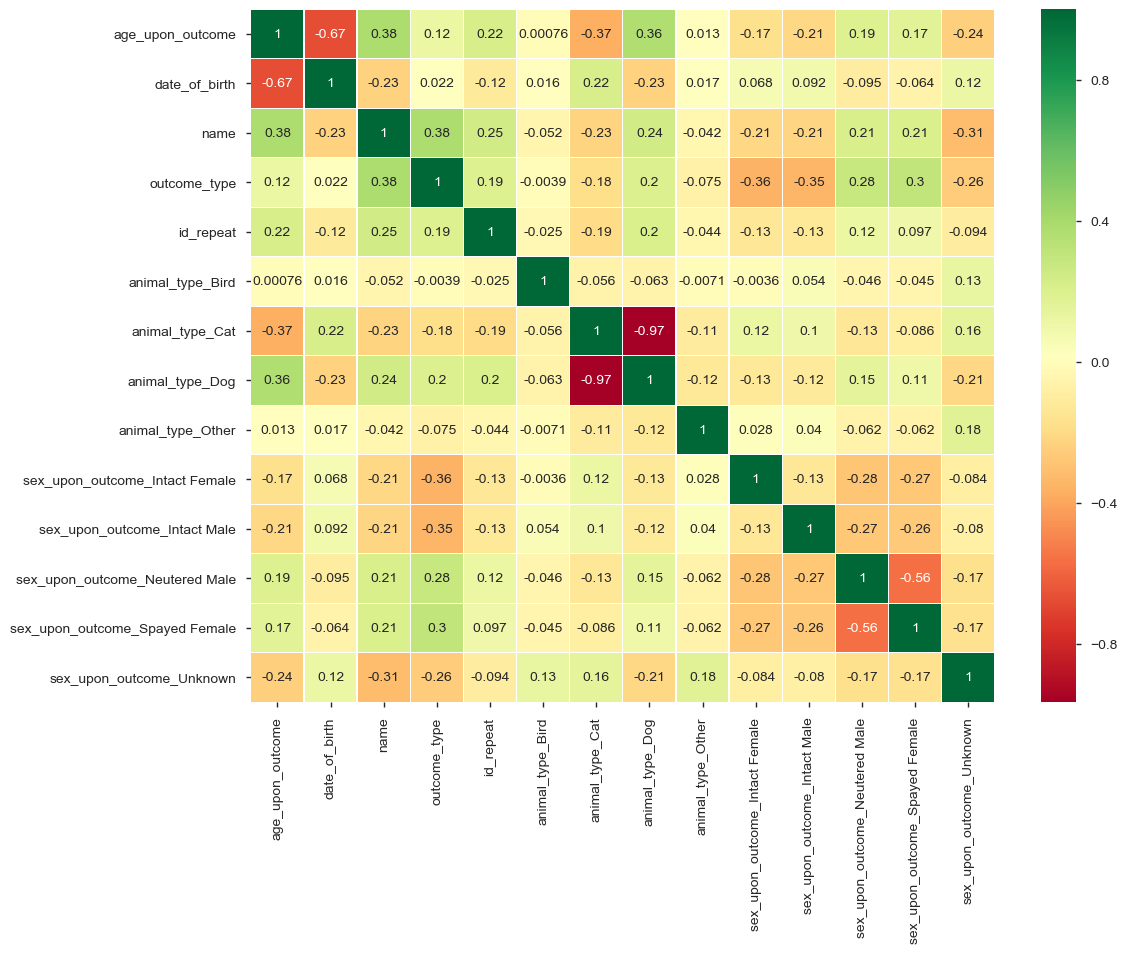

In [51]:
rcParams['figure.figsize'] = 12,9

ax = sns.heatmap(df.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [52]:
df.columns

Index(['age_upon_outcome', 'date_of_birth', 'name', 'outcome_type',
       'id_repeat', 'animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog',
       'animal_type_Other', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown'],
      dtype='object')

Посмотрим на матрицы корреляции для каждого типа животного. Они очень сильно отличаются. Кроме того, выборка сильно несбалансирована - большинство питомцев (97%) - кошки или собаки

In [53]:
df_dog = df.query('animal_type_Dog == 1').drop(columns=['animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog', 
                                               'animal_type_Other'])

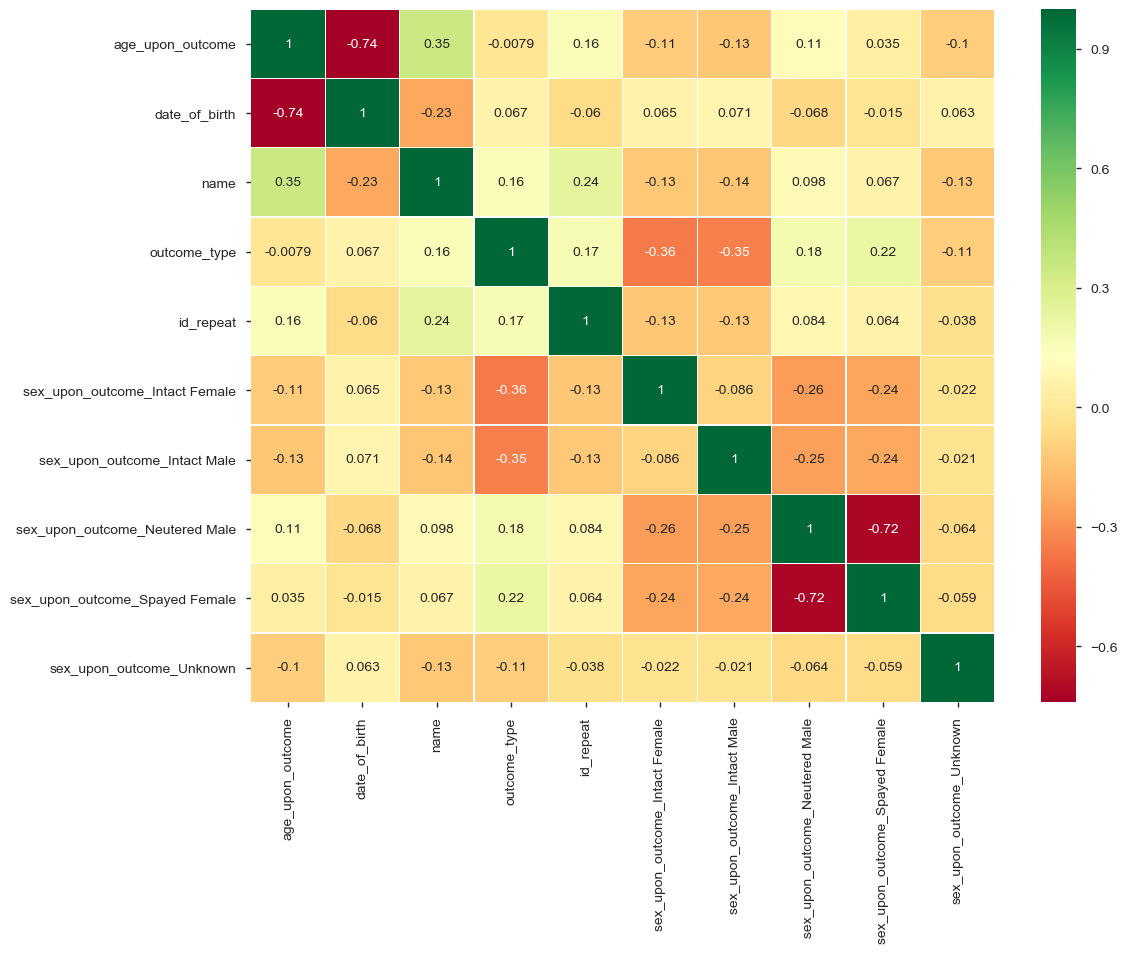

In [54]:
ax = sns.heatmap(df_dog.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [55]:
df_cat = df.query('animal_type_Cat == 1').drop(columns=['animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog', 
                                               'animal_type_Other'])

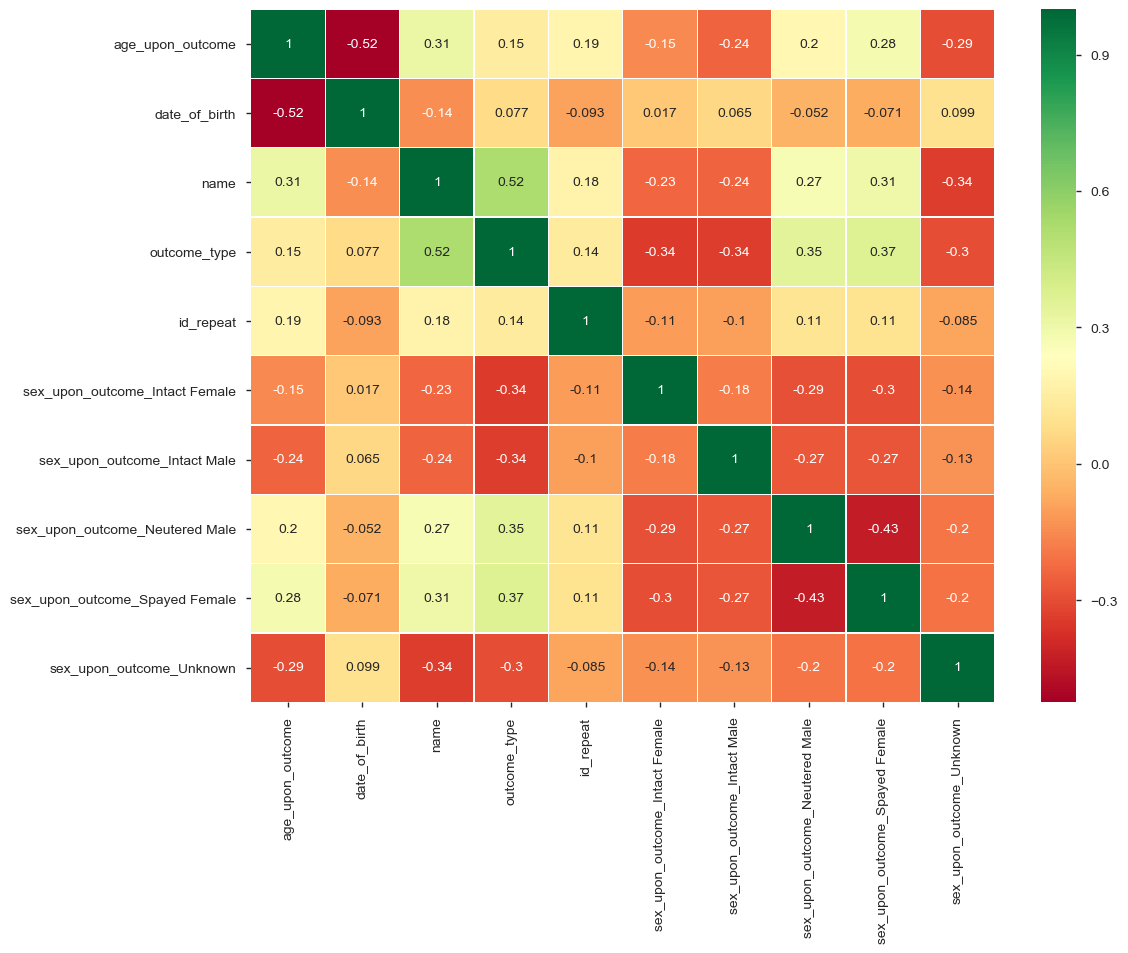

In [56]:
ax = sns.heatmap(df_cat.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [57]:
df_bird = df.query('animal_type_Bird == 1').drop(columns=['animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog', 
                                               'animal_type_Other'])

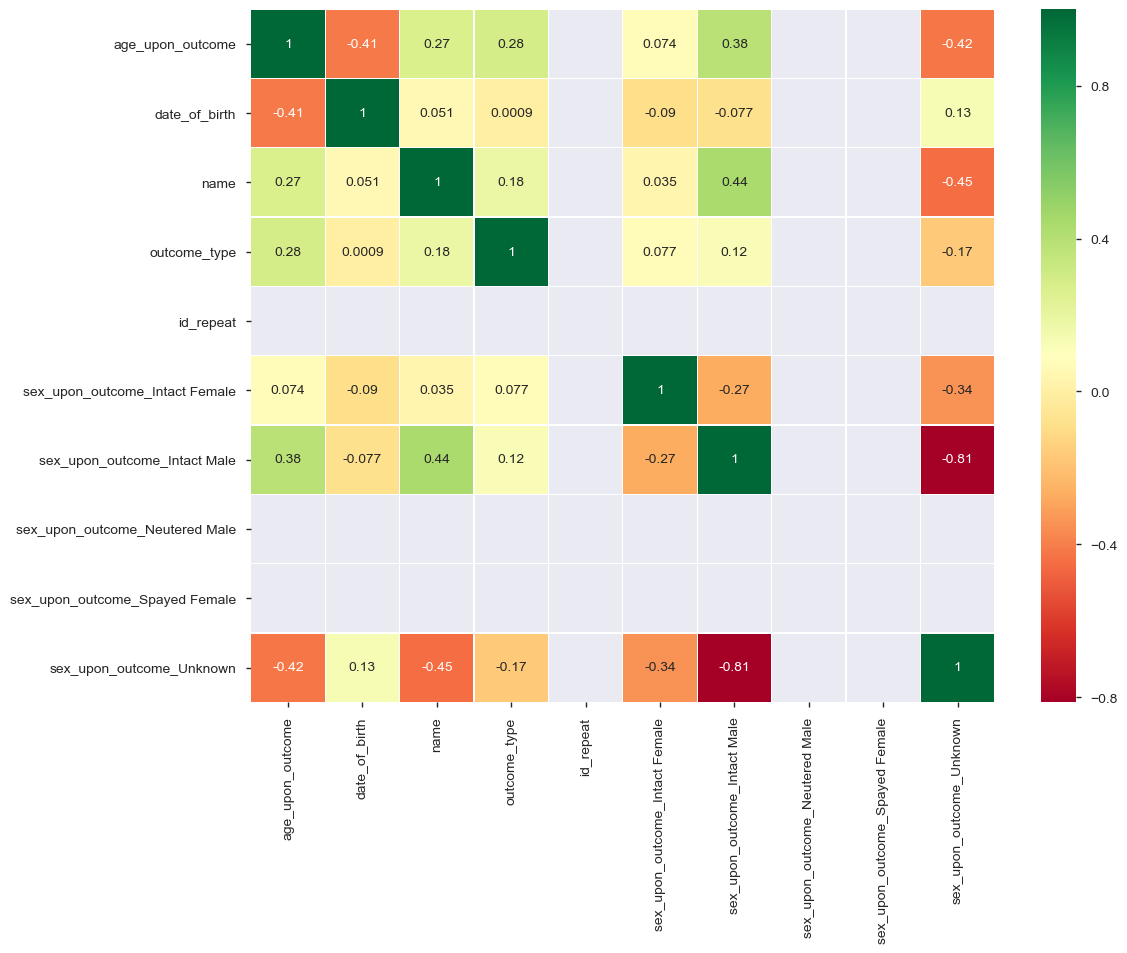

In [58]:
ax = sns.heatmap(df_bird.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [59]:
df_other = df.query('animal_type_Other == 1').drop(columns=['animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog', 
                                               'animal_type_Other'])

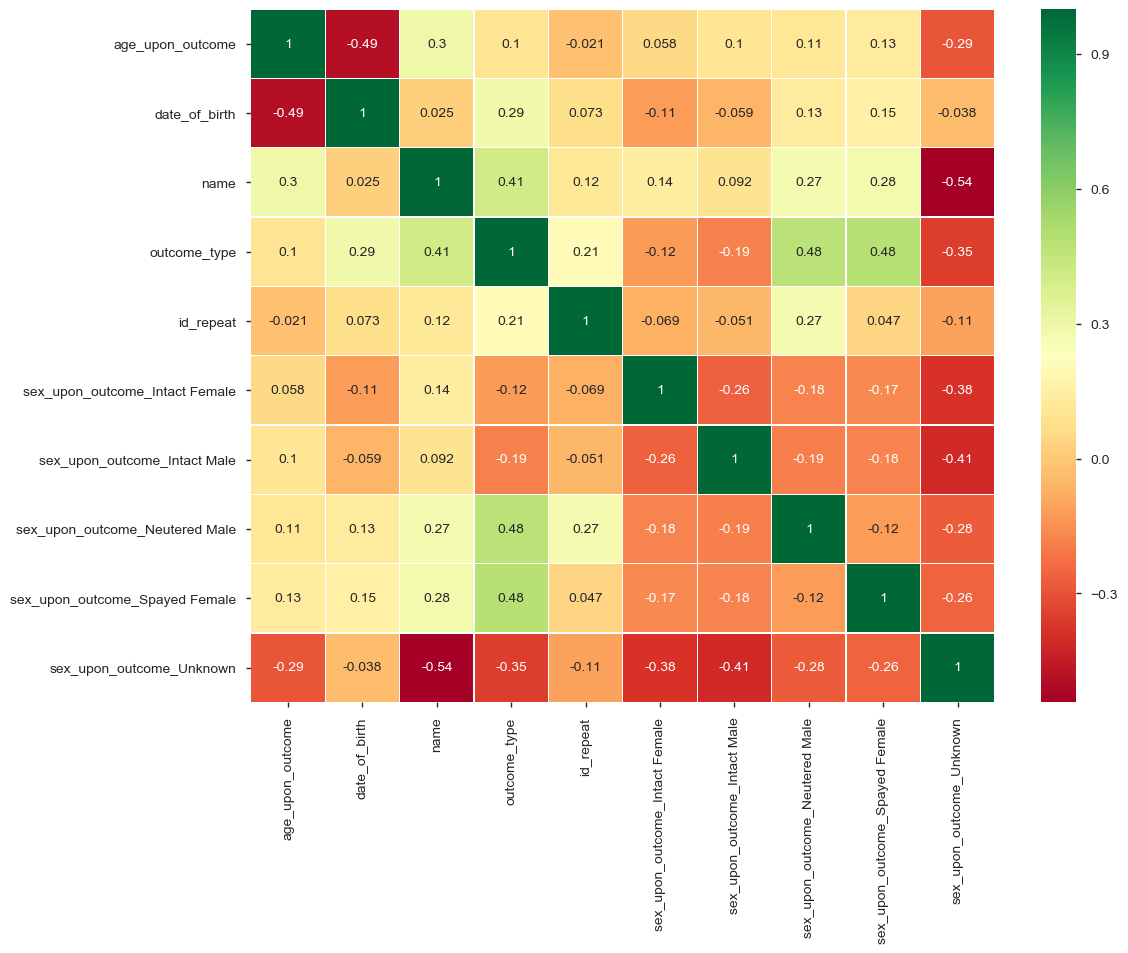

In [60]:
ax = sns.heatmap(df_other.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

Матрицы корреляции отличаются достаточно сильно. Попробуем поработать с данными по отдельности. Ну и размерность меньше. Первыми возьмем кошек

# Cat model

In [61]:
profile = pandas_profiling.ProfileReport(df_cat)
profile.to_file(outputfile='report_df_cat.html')

По матрице корреляций видно, что наиболее сильно выбор зависит от наличия имени и от пола. 

In [62]:
# Normalize values - not nessesary, just for play
df_cat['age_upon_outcome'] = (df_cat['age_upon_outcome'] - df_cat['age_upon_outcome'].min())/(
    df_cat['age_upon_outcome'].max() - df_cat['age_upon_outcome'].min())

df_cat['date_of_birth'] = (df_cat['date_of_birth'] - df_cat['date_of_birth'].min())/(
    df_cat['date_of_birth'].max() - df_cat['date_of_birth'].min())

df_cat['id_repeat'] = (df_cat['id_repeat'] - df_cat['id_repeat'].min())/(
    df_cat['id_repeat'].max() - df_cat['id_repeat'].min())

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [64]:
df_cat.columns

Index(['age_upon_outcome', 'date_of_birth', 'name', 'outcome_type',
       'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown'],
      dtype='object')

In [65]:
X = df_cat[['age_upon_outcome', 'date_of_birth', 'name', 'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown']]
y = df_cat['outcome_type']

In [66]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                            Specs        Score
2                            name  3032.277108
4  sex_upon_outcome_Intact Female  2535.895345
5    sex_upon_outcome_Intact Male  2511.768552
7  sex_upon_outcome_Spayed Female  2420.377350
6  sex_upon_outcome_Neutered Male  2209.005221
8        sex_upon_outcome_Unknown  2110.901133
3                       id_repeat   141.137633
0                age_upon_outcome     5.982952
1                   date_of_birth     0.179259


Для кошек наиболее значимыми признаками являются наличие имени и пол. 

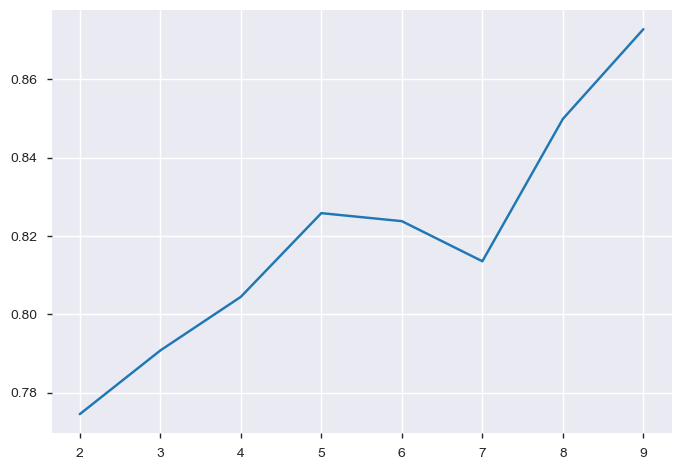

In [69]:
features_list = featureScores.nlargest(15,'Score')['Specs'].to_list()

num_feat = np.zeros(len(features_list) - 1)
score_list = np.zeros(len(features_list) - 1)

for i in range(2, len(features_list)+1):
#     print(features_list[:i])
    cur_f_list = features_list[:i]
    X = df_cat[cur_f_list]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    cat_model = RandomForestClassifier(n_estimators=100)
    cat_model.fit(X_train, y_train)
    score_list[i-2] = cat_model.score(X_test, y_test)
    num_feat[i-2] = i
    
# print(score_list)
plt.plot(num_feat, score_list)
plt.show()

In [70]:
df_cat.columns

Index(['age_upon_outcome', 'date_of_birth', 'name', 'outcome_type',
       'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown'],
      dtype='object')

### Cat model Results

In [71]:
# Selecting columns for training set
# X = df_cat[['name', 'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Neutered Male', 
#            'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Spayed Female']]

X = df_cat[['sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female']]

y = df_cat['outcome_type']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
cat_model = RandomForestClassifier(n_estimators=100)
cat_model.fit(X_train, y_train)

cat_model.score(X_test, y_test)

0.8330134357005758

Лучший результат для кошек на 2-х столбцах - 0,83

In [74]:
X = df_cat[['age_upon_outcome', 'date_of_birth', 'name', 'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown']]
y = df_cat['outcome_type']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [76]:
cat_model = RandomForestClassifier(n_estimators=100)
cat_model.fit(X_train, y_train)

cat_model.score(X_test, y_test)

0.8775431861804223

Результат для кошек на полном наборе столбцов - 0,87

# Dog model

In [77]:
profile = pandas_profiling.ProfileReport(df_dog)
profile.to_file(outputfile='report_df_dog.html')

In [78]:
X = df_dog[['age_upon_outcome', 'date_of_birth', 'name', 'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown']]
y = df_dog['outcome_type']

In [79]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                            Specs        Score
4  sex_upon_outcome_Intact Female  3499.086775
5    sex_upon_outcome_Intact Male  3255.187414
7  sex_upon_outcome_Spayed Female   868.007207
6  sex_upon_outcome_Neutered Male   538.191403
8        sex_upon_outcome_Unknown   326.563518
0                age_upon_outcome   305.314057
3                       id_repeat   219.884036
2                            name   153.061364
1                   date_of_birth    30.584357


In [89]:
X = df_dog[['sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male', 
            'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Neutered Male']]
y = df_dog['outcome_type']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

dog_model = RandomForestClassifier(n_estimators=100, max_features=4)
dog_model.fit(X_train, y_train)

dog_model.score(X_test, y_test)

0.8085897869462293

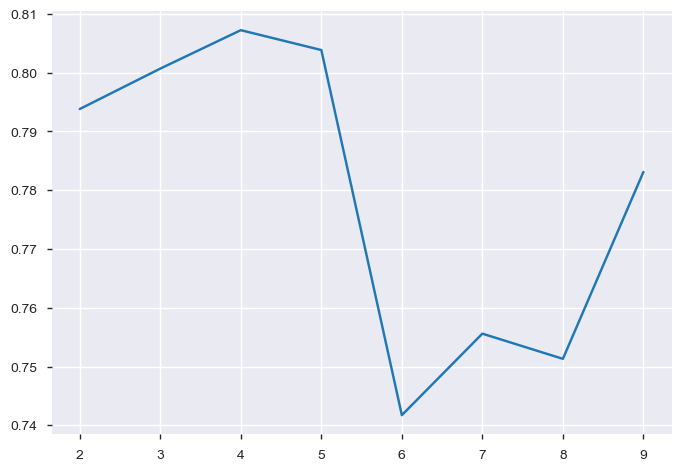

In [88]:
features_list = featureScores.nlargest(15,'Score')['Specs'].to_list()

num_feat = np.zeros(len(features_list) - 1)
score_list = np.zeros(len(features_list) - 1)

for i in range(2, len(features_list)+1):
#     print(features_list[:i])
    cur_f_list = features_list[:i]
    X = df_dog[cur_f_list]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    dog_model = RandomForestClassifier(n_estimators=100, max_features=i)
    dog_model.fit(X_train, y_train)
    score_list[i-2] = dog_model.score(X_test, y_test)
    num_feat[i-2] = i
    
# print(score_list)
plt.plot(num_feat, score_list)
plt.show()

Забавный график - наилучший результат модели достигается при выборе первых 4-х свойств (различные комбинации пола)

# Bird model

In [91]:
# Remove columns with only single value
df_bird = df_bird.drop(columns=['id_repeat', 'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Neutered Male'])

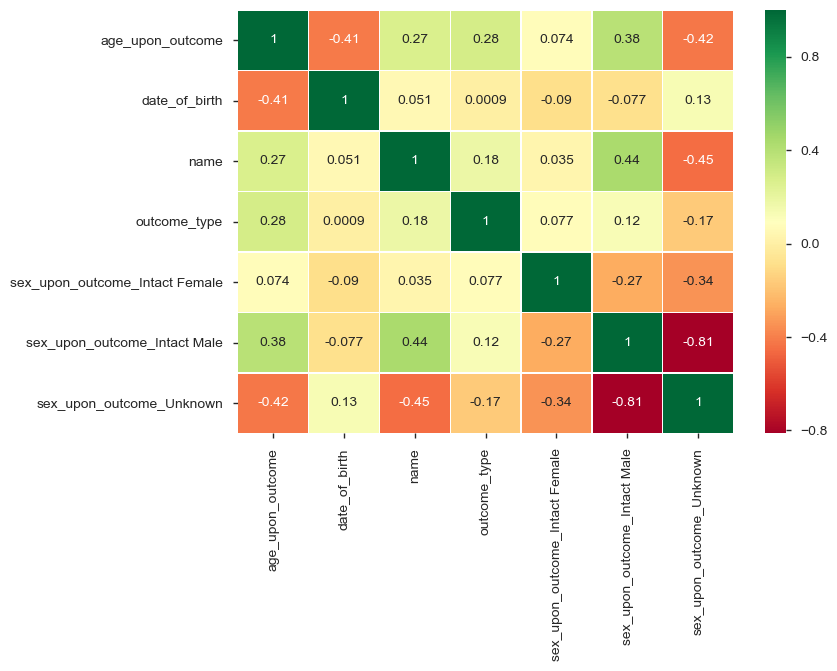

In [92]:
ax = sns.heatmap(df_bird.corr(method='spearman'), annot=True, linewidths=0.2, cmap='RdYlGn')

In [93]:
profile = pandas_profiling.ProfileReport(df_bird)
profile.to_file(outputfile='report_df_bird.html')

In [94]:
X = df_bird[['age_upon_outcome', 'date_of_birth', 'name', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Unknown']]
y = df_bird['outcome_type']

In [95]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                            Specs     Score
2                            name  4.780928
5        sex_upon_outcome_Unknown  2.846334
4    sex_upon_outcome_Intact Male  1.904568
3  sex_upon_outcome_Intact Female  1.090135
1                   date_of_birth  0.017621
0                age_upon_outcome  0.003035


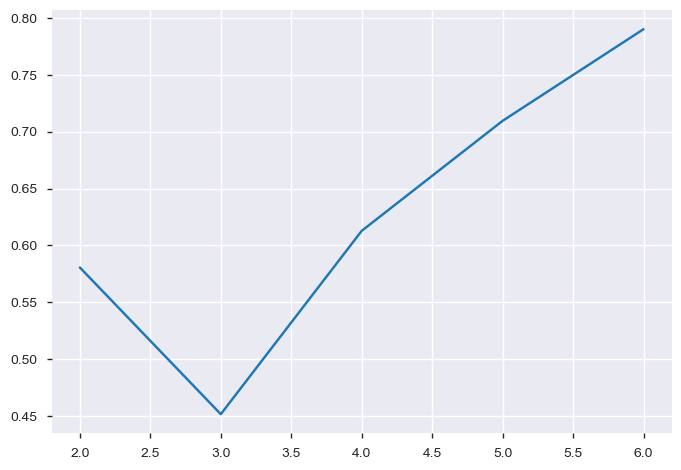

In [96]:
features_list = featureScores.nlargest(15,'Score')['Specs'].to_list()

num_feat = np.zeros(len(features_list) - 1)
score_list = np.zeros(len(features_list) - 1)

for i in range(2, len(features_list)+1):
#     print(features_list[:i])
    cur_f_list = features_list[:i]
    X = df_bird[cur_f_list]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    bird_model = RandomForestClassifier(n_estimators=100)
    bird_model.fit(X_train, y_train)
    score_list[i-2] = bird_model.score(X_test, y_test)
    num_feat[i-2] = i
    
# print(score_list)
plt.plot(num_feat, score_list)
plt.show()

In [98]:
# Best result - with using all features
X = df_bird[['age_upon_outcome', 'date_of_birth', 'name', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Unknown']]
y = df_bird['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
bird_model = RandomForestClassifier(n_estimators=100)
bird_model.fit(X_train, y_train)
bird_model.score(X_test, y_test)

0.8064516129032258

# Other Model

In [99]:
profile = pandas_profiling.ProfileReport(df_other)
profile.to_file(outputfile='report_df_other.html')

In [100]:
X = df_other[['age_upon_outcome', 'date_of_birth', 'name', 
       'id_repeat', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown']]
y = df_other['outcome_type']

In [101]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                            Specs       Score
7  sex_upon_outcome_Spayed Female  164.879033
6  sex_upon_outcome_Neutered Male  156.042911
2                            name   62.317203
8        sex_upon_outcome_Unknown   61.097059
5    sex_upon_outcome_Intact Male   20.970653
4  sex_upon_outcome_Intact Female    9.706911
0                age_upon_outcome    5.059140
1                   date_of_birth    2.798860
3                       id_repeat    0.617322


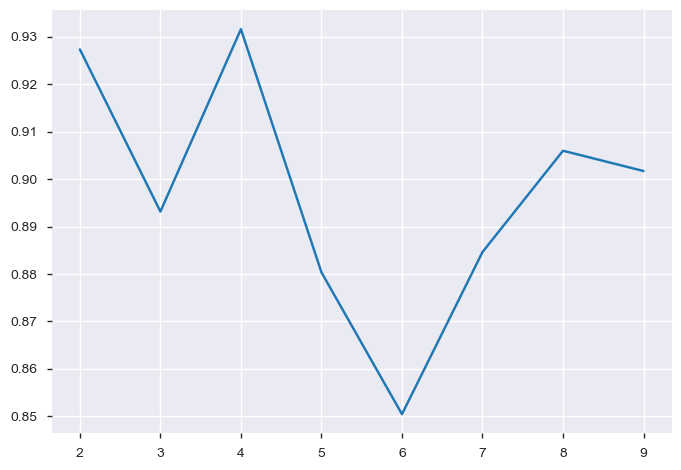

In [110]:
features_list = featureScores.nlargest(15,'Score')['Specs'].to_list()

num_feat = np.zeros(len(features_list) - 1)
score_list = np.zeros(len(features_list) - 1)

for i in range(2, len(features_list)+1):
#     print(features_list[:i])
    cur_f_list = features_list[:i]
    X = df_other[cur_f_list]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    other_model = RandomForestClassifier(n_estimators=100)
    other_model.fit(X_train, y_train)
    score_list[i-2] = other_model.score(X_test, y_test)
    num_feat[i-2] = i
    
# print(score_list)
plt.plot(num_feat, score_list)
plt.show()

Графики получаются чуть разные, в зависимости от разбиения. В целом, на первых двух свойствах (стерилизованные самцы и самки) результат около 0.91-0.92, на полном наборе свойств - чуть ниже, 0.9-0.91

# Full dataset model - without splitting

In [111]:
df.columns

Index(['age_upon_outcome', 'date_of_birth', 'name', 'outcome_type',
       'id_repeat', 'animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog',
       'animal_type_Other', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown'],
      dtype='object')

In [112]:
X = df[['age_upon_outcome', 'date_of_birth', 'name',
       'id_repeat', 'animal_type_Bird', 'animal_type_Cat', 'animal_type_Dog',
       'animal_type_Other', 'sex_upon_outcome_Intact Female',
       'sex_upon_outcome_Intact Male', 'sex_upon_outcome_Neutered Male',
       'sex_upon_outcome_Spayed Female', 'sex_upon_outcome_Unknown']]
y = df['outcome_type']

In [113]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                             Specs        Score
8   sex_upon_outcome_Intact Female  6355.062544
9     sex_upon_outcome_Intact Male  6037.612856
12        sex_upon_outcome_Unknown  3560.694175
11  sex_upon_outcome_Spayed Female  3402.590011
10  sex_upon_outcome_Neutered Male  2838.996301
2                             name  2599.664745
6                  animal_type_Dog  1058.208481
5                  animal_type_Cat   994.153094
3                        id_repeat   391.905428
7                animal_type_Other   309.847364
0                 age_upon_outcome   117.736998
1                    date_of_birth     1.583063
4                 animal_type_Bird     0.842856


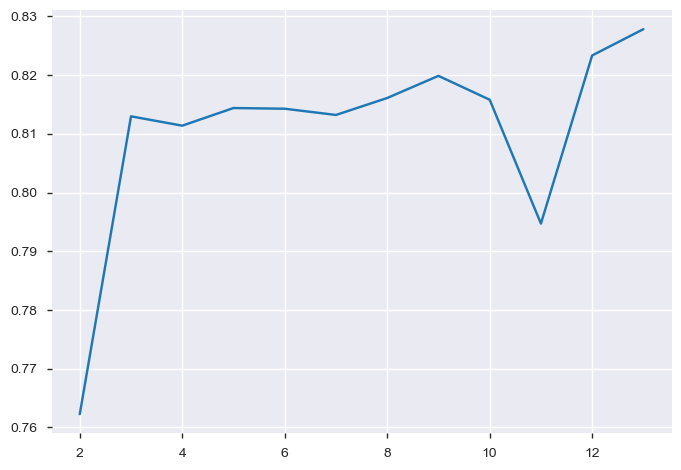

In [114]:
features_list = featureScores.nlargest(15,'Score')['Specs'].to_list()

num_feat = np.zeros(len(features_list) - 1)
score_list = np.zeros(len(features_list) - 1)

for i in range(2, len(features_list)+1):
#     print(features_list[:i])
    cur_f_list = features_list[:i]
    X = df[cur_f_list]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    df_model = RandomForestClassifier(n_estimators=100)
    df_model.fit(X_train, y_train)
    score_list[i-2] = df_model.score(X_test, y_test)
    num_feat[i-2] = i
    
# print(score_list)
plt.plot(num_feat, score_list)
plt.show()

В целом, на полном датасете есть формальное улучшение предсказаний для классов собак и птиц, но, имхо, это за счет худшего предсказания кошек. Также, полный датасет перестает быть сбалансированным...